# Disease Detection from CT Scans by 3D CNN

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling3D, Input, ZeroPadding3D, BatchNormalization, MaxPooling3D, Concatenate, AveragePooling3D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv3D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from keras_addon import ImageFrameGenerator
from importlib import reload
from sklearn.model_selection import train_test_split

In [3]:
#path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/CT_scans/'
path = '/nfs/turbo/umms-awaljee/wsliu/Data/CT_scans/'
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

In [4]:
batch_size = 4
G = 4

## Prepare Data Generators

In [5]:
df = pd.read_excel(path+'K23_Crohn_RadiologyReport_Labels_27MAR2018.xlsx')

df = df.dropna(subset=['StudyID'])

df['filename'] = ['s'+str(int(f)) for f in df['StudyID']]

df = df.drop_duplicates(subset=['filename'])

df = df.reset_index(drop=True)

In [8]:
df.columns

Index(['Database_ID', 'StudyID', 'Ileum', 'ascending', 'transverse',
       'Descending', 'Sigmoid', 'rectum', 'prox_small_bowel', 'Prox_Ileum',
       'Jejunum', 'Duodenum', 'Stomach', 'Esophagus', 'fistula_enteral',
       'fistula_perianal', 'abscess_enteral', 'abscess_perianal',
       'StrictureNoted', 'Bowel_Dilation_Noted', 'Lumen_Narrowing_Noted',
       'Prior_Surgery', 'Ostomy', 'Pouch', 'CD_Active_AnyLocation',
       'CD_Active_SmallBowel', 'CD_Active_RtColon', 'CD_Active_LtColon',
       'CD_Active_Pancolitis', 'Fistula_Any', 'Abscess_any',
       'Stricture_Suspected', 'Surgery_Prior_Any', 'filename'],
      dtype='object')

In [6]:
df.shape

(3477, 34)

In [16]:
df['CD_Active_AnyLocation'].value_counts(dropna=False)

1    2127
0    1353
Name: CD_Active_AnyLocation, dtype: int64

In [5]:
df = pd.read_csv(path+'train_labels.csv')

In [6]:
val_size = int(len(df)*0.125/8)*8

trn_size = int((len(df)-val_size)/8)*8

trn_df, val_df = train_test_split(df, test_size=val_size, train_size=trn_size, random_state=24, 
                                  stratify=df[['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any']])

In [7]:
trn_df, tst_df = train_test_split(df, test_size=0.15, stratify=df[['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any']], 
                                 random_state=24)

In [7]:
len(trn_df), len(val_df)

(2584, 368)

In [13]:
trn_df.to_csv(path+'train_labels.csv', index=False)
tst_df.to_csv(path+'tst_labels.csv', index=False)

In [19]:
tst_df = pd.read_csv(path+'tst_labels.csv')

In [20]:
trn_df['Fistula_Any'].value_counts(dropna=False)

0    2219
1     365
Name: Fistula_Any, dtype: int64

In [21]:
tst_df['Abscess_any'].value_counts()

0    495
1     27
Name: Abscess_any, dtype: int64

In [6]:
import keras_addon
reload(keras_addon)
from keras_addon import ImageFrameGenerator

In [8]:
gen = ImageFrameGenerator()

In [9]:
trn_itr = gen.flow_from_frame(path+'ndarray/', trn_df, 'filename', ['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'], 
                             target_size=(224, 224, 128), color_mode='3d', batch_size=batch_size*G)

Found 3474 images in the directory.
Using CD_Active_AnyLocation as continuous label. 
Using Fistula_Any as continuous label. 
Using Abscess_any as continuous label. 
Using 2581 images to generate mini-batches.


In [10]:
val_itr = gen.flow_from_frame(path+'ndarray/', val_df, 'filename', ['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'], 
                             target_size=(224, 224, 128), color_mode='3d', batch_size=batch_size*G)

Found 3474 images in the directory.
Using CD_Active_AnyLocation as continuous label. 
Using Fistula_Any as continuous label. 
Using Abscess_any as continuous label. 
Using 368 images to generate mini-batches.


In [10]:
tst_itr = gen.flow_from_frame(path+'ndarray/', tst_df, 'filename', ['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'], 
                             target_size=(256, 256, 192), color_mode='3d', batch_size=batch_size*G, shuffle=False)

Found 3474 images in the directory.
Using CD_Active_AnyLocation as continuous label. 
Using Fistula_Any as continuous label. 
Using Abscess_any as continuous label. 
Using 696 images to generate mini-batches.


In [29]:
from utils3d import plot_ndarray

In [42]:
x = X[1,:,:,:,0]

In [31]:
x = np.load(path+'low_resolution/s91220.npy')

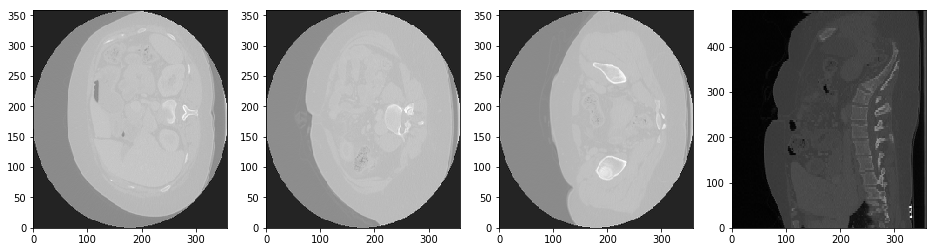

In [32]:
plot_ndarray(x)

In [33]:
x.nbytes

12845056

## Model Building

In [11]:
from dense3dnet import Dense3DNet

In [12]:
blocks = [6, 12, 24, 16]

In [13]:
with tf.device('/cpu:0'):
    base_model = Dense3DNet(blocks, growth_rate=12, input_shape=(224, 224, 128, 1), pooling='avg')

    x = base_model.output
    output_CD = Dense(1, activation='sigmoid', name='CD_Active_AnyLocation')(x)
    output_fist = Dense(1, activation='sigmoid', name='Fistula_Any')(x)
    output_absc = Dense(1, activation='sigmoid', name='Abscess_any')(x)

    model = Model(inputs=base_model.input, outputs=[output_CD, output_fist, output_absc])

In [14]:
parallel_model = multi_gpu_model(model, gpus=G)

In [15]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 128 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 224, 224, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [16]:
parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
parallel_model.compile(optimizer='adam', loss={'CD_Active_AnyLocation':'binary_crossentropy', 'Fistula_Any':'binary_crossentropy', 
                                     'Abscess_any':'binary_crossentropy'}, metrics=['accuracy'], 
             loss_weights={'CD_Active_AnyLocation':1., 'Fistula_Any':1., 'Abscess_any':1.})

In [17]:
hist = parallel_model.fit_generator(trn_itr, steps_per_epoch=trn_itr.n // (batch_size*G), epochs=2, validation_data=val_itr, 
                    validation_steps=val_itr.n // (batch_size*G))

Epoch 1/2
 38/161 [======>.......................] - ETA: 2:11:01 - loss: 1.8734 - CD_Active_AnyLocation_loss: 0.6953 - Fistula_Any_loss: 0.6249 - Abscess_any_loss: 0.5532 - CD_Active_AnyLocation_acc: 0.5740 - Fistula_Any_acc: 0.7352 - Abscess_any_acc: 0.8289

KeyboardInterrupt: 

## Result Evaluation

In [23]:
parallel_model.load_weights(model_path+'dense121_gr12_3output0515_f.h5')

In [15]:
tst_df = pd.read_csv(path+'test_labels.csv')

In [16]:
gen = ImageFrameGenerator()
tst_itr =  gen.flow_from_frame(path+'ndarray/', tst_df, 'filename', ['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'], 
                             label_types=['binary']*3, target_size=(256, 256, 192), color_mode='3d', 
                               batch_size=batch_size*G, shuffle=False)

Found 3474 images in the directory.
Using CD_Active_AnyLocation as binary label. 
Using Fistula_Any as binary label. 
Using Abscess_any as binary label. 
Using 696 images to generate mini-batches.


In [24]:
y = parallel_model.predict_generator(tst_itr, verbose=1)

87/87 [==============================] - 256s 3s/step


In [25]:
y_pred = np.concatenate(y, axis=1)

In [43]:
y_pred = y.reshape(y.shape[0])

In [19]:
y_true = tst_df[['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any']].values

In [20]:
y_pred.shape, y_true.shape

((696, 3), (696, 3))

In [21]:
y_true = tst_df['Abscess_any'].values

In [21]:
from DL_utils import plot_roc

{0: 0.6069199044931626, 1: 0.6519520851818988, 2: 0.5851307542684245}

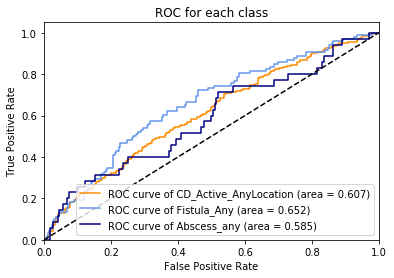

In [26]:
plot_roc(y_pred, y_true, classes=['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'])

{0: 0.5754721076622531, 1: 0.5945839874411303, 2: 0.6496650097255241}

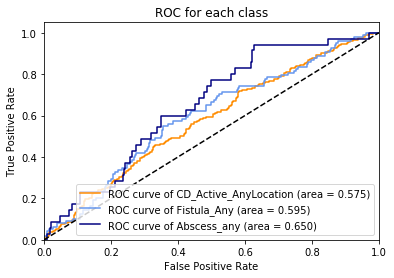

In [22]:
plot_roc(y_pred, y_true, classes=['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'])